# Eigengene SVA Analysis

**Created**: 13 December 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(data.table)
library(parallel)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
geno <- fread("~/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")
colnames(geno) <- c("chr", "snp", "cM", "pos", "minor", "major")

## Manhattan Plots

The genome-wide significance threshold is calculated using a Bonferroni correction of a significance threshold of 0.05. We performed tests for 66 individual eigengenes for 70300 SNPs. This threshold is slightly larger than 1e-8, so I will use that cutoff instead.

Under the null distribution, $t=\frac{\hat{\beta}}{SE}$ follows a T distribution with degrees of freedom close to $n$. The genomic inflation score measures the deviation from this expected distribution while accounting for outliers expected from a few true positives. The score is

$$\lambda = \frac{\text{median}(t^2)}{\text{median}(\chi_1^2)}$$

where $t$ is the T-statistic for $\beta$. Here, we assume that the T Distribution can be approximated as a standard normal distribution since $n$ is relatively large.

In [4]:
me.assocs <- do.call(rbind, lapply(list.files("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", pattern="*.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
}))

In [5]:
lambdas <- me.assocs %>%
    dplyr::group_by(me) %>%
    dplyr::summarize(lambda = median(qchisq(1 - p, 1)) / qchisq(0.5, 1))

In [27]:
me.assocs %>%
    dplyr::filter(p < 0.05 / (106 * 70968)) %>%
    merge(., geno, by="snp") %>%
    dplyr::group_by(me, chr) %>%
    dplyr::slice_min(p, n=1) %>%
    dplyr::arrange(me)

snp,beta,se,t,p,me,chr,cM,pos,minor,major
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
rs582717,0.013268366,0.0010161510,13.057476,9.819997e-35,ME_101,1,0,25400345,C,T
rs1131017,-0.012402898,0.0010199861,-12.159869,1.001692e-30,ME_101,12,0,56042145,C,G
rs629329,0.029716084,0.0014781992,20.102895,9.204765e-70,ME_102,17,0,18377593,A,G
rs4761234,-0.006748100,0.0005868704,-11.498451,4.488238e-28,ME_103,12,0,69338325,C,T
rs36053285,-0.027772998,0.0009853585,-28.185677,3.561824e-113,ME_104,15,0,100574435,C,T
rs1757183,0.020068184,0.0009805332,20.466604,3.690375e-71,ME_105,6,0,37517014,T,C
rs7395319,-0.017864361,0.0011366742,-15.716342,1.047548e-47,ME_106,11,0,331326,C,T
rs10936664,0.005185452,0.0007761728,6.680796,5.300655e-11,ME_47,3,0,101496512,T,C
rs844824,-0.011300627,0.0012010050,-9.409309,9.377902e-20,ME_64,20,0,23102180,G,C


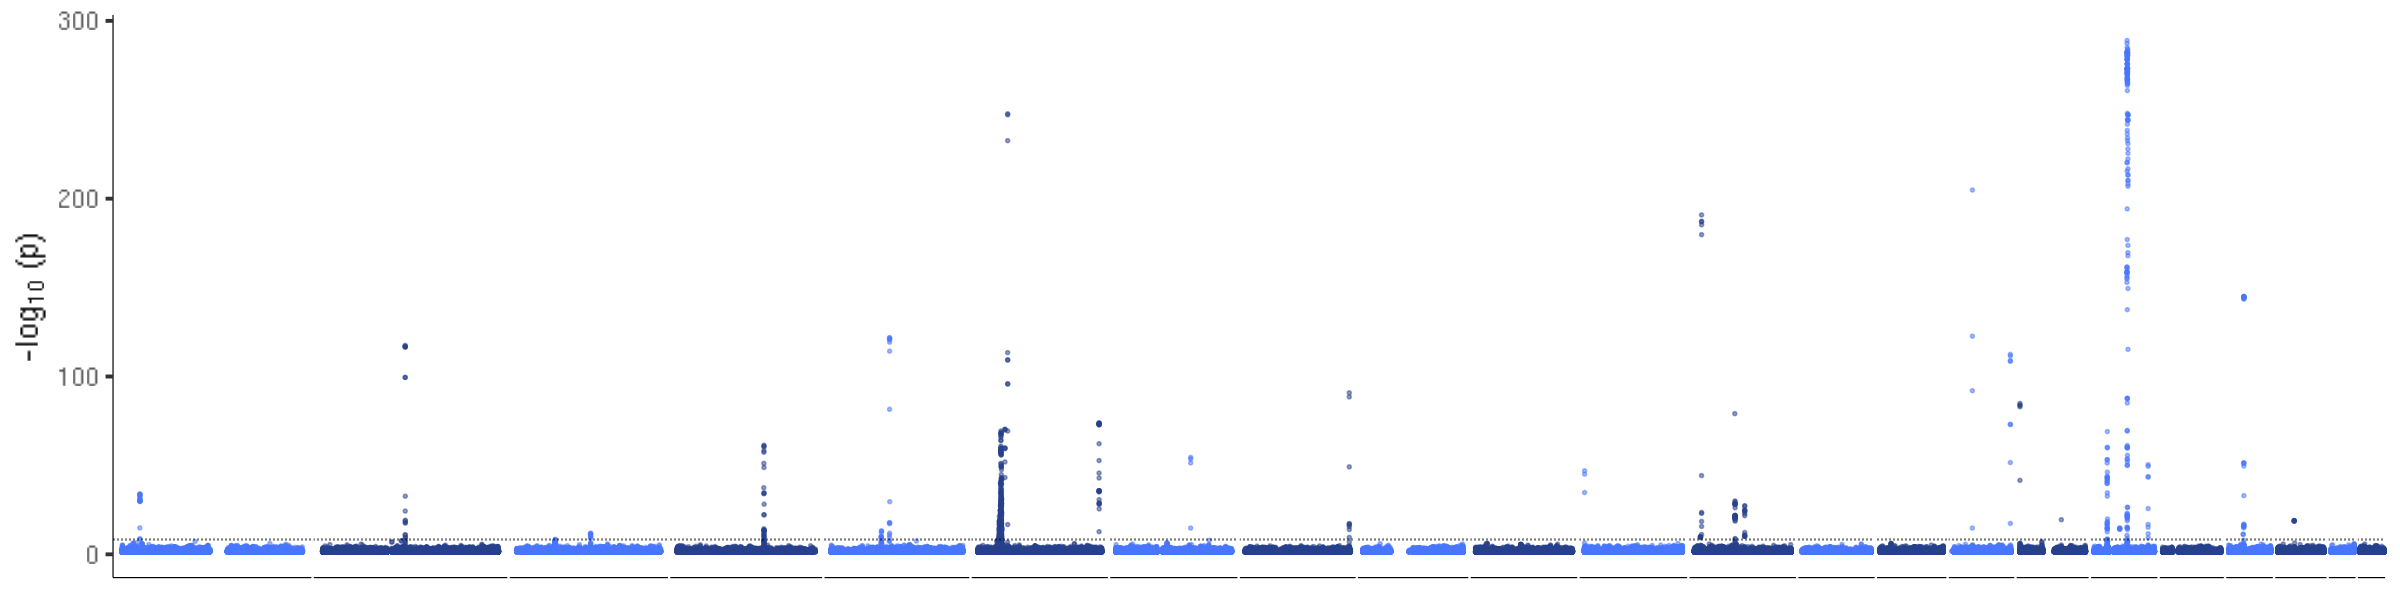

In [26]:
options(repr.plot.width=20, repr.plot.height=5)

plot.data <- me.assocs %>%
    dplyr::filter(p < 0.05) %>%
    merge(., geno, by="snp") %>%
    dplyr::filter(chr %in% 1:22) %>%
    dplyr::mutate(chr=factor(chr, levels=1:22)) %>%
    dplyr::mutate(chr.type=ifelse(as.numeric(chr) %% 2 == 0, "Even", "Odd")) %>%
    dplyr::mutate(Log.10.p = -log10(p))

plot.data %>%
    ggplot() +
    geom_point(aes(x=pos, y=Log.10.p, color=chr.type), size=I(0.5), alpha=0.5) +
    geom_hline(yintercept=-log10(0.05 / (106 * 70968)), lty=3, size=0.5) +
    scale_color_manual(values=c("Even" = "royalblue4", "Odd" = "royalblue1")) +
    facet_grid(~chr, scale="free_x", space="free_x") +
    guides(color="none") +
    xlab("Position") + ylab(expression('-log'[10]~'(p)')) +
    ggplot_theme +
    theme(
        strip.background=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.spacing=unit(0.1, "lines"),
        strip.text=element_blank(),
        axis.title.x=element_blank()
    )

ggsave("04_Expression/results/manhattan_initial_pass.png", width=20, height=5, dpi=1200)

## P-Value Q-Q Plots

Under the null hypothesis, we expect p-values for multiple tests to have a uniform distribution. If there is inflation in the data (that is, variants are associated with the quantitative variable due to population stratification), this p-value distribution will be skewed towards significance. This is quantified with the genomic inflation factor ($\lambda$). We can also plot the Q-Q plot for the p-values to check for deviation from the expected distribution. The p-values for true significant hits (close to 0) should deviate from the distribution, but the rest (indicating true negatives) should follow the distribution faithfully.

In [ ]:
me.assocs <- lapply(c("ME_1.tsv", "ME_59.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
})

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

exp.p.assocs <- lapply(me.assocs, function(me.assoc) {
    me.assoc %>%
        as.data.frame() %>%
        dplyr::mutate(expected.p=(rank(p, ties.method="first") + 0.5) / (length(p) + 1)) %>%
        dplyr::mutate(Log.10.P=-log10(p)) %>%
        dplyr::mutate(Expected.Log.10.P=-log10(expected.p))
})

plots <- lapply(exp.p.assocs, function(exp.p.assoc) {
    dplyr::bind_rows(
        exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P < 5) %>% dplyr::sample_frac(0.001),
        exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P >= 5)
    ) %>%
        ggplot() +
        geom_point(aes(x=Expected.Log.10.P, y=Log.10.P)) +
        geom_abline(slope=1, intercept=0, color="firebrick1") +
        xlab(expression("Expected -log"[10]~"(p)")) +
        ylab(expression("Actual -log"[10]~"(p)")) +
        ggplot_theme
})

plots[[1]] + plots[[2]]

## Module Information

In [ ]:
mod.info <- read.csv("~/gains_team282/nikhil/expression/gene_expression_annotations/xCell_Signatures.csv", row.names=1)

In [ ]:
mod.info %>%
    dplyr::filter(Module == "Module_1" | Module == "Module_59")

## Conditional Analysis

In [ ]:
library(data.table)
library(lme4)
library(parallel)

In [ ]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv")

In [ ]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt") %>%
    t() %>% as.data.frame()

In [ ]:
lead.cis.eqtl <- read.table("/nfs/users/nfs_n/nm18/gains_team282/eqtl/cisresults/eigenMT/ciseqtl_eigenMT_corrected.txt")

In [ ]:
mod.1.info <- merge(modules, lead.cis.eqtl, by.x="Gene", by.y="gene") %>%
    dplyr::filter(Module == "Module_1", Sig)

mod.59.info <- merge(modules, lead.cis.eqtl, by.x="Gene", by.y="gene") %>%
    dplyr::filter(Module == "Module_59", Sig)

In [ ]:
"ENSG00000079313" %in% mod.59.info$Gene

In [ ]:
# Design Matrix
design.matrix <- read.csv("/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/eigengene_sva/mapping_data.csv")

# Genotype Matrix
genotypes <- fread("/nfs/users/nfs_n/nm18/gains_team282/nikhil/data/genotypes/eigengene_sva_genotypes.raw", sep=" ", drop=2:6)

# Clean Genotype Matrix
patient.sample.match <- match(design.matrix$GAinS.ID, genotypes$FID)
genotypes <- genotypes[patient.sample.match,]
colnames(genotypes) <- gsub("X", "", colnames(genotypes))
colnames(genotypes) <- sapply(strsplit(colnames(genotypes), "_"), function(x) { x[1] })
genotypes[, 1] <- NULL
genotypes <- as.matrix(genotypes)
rownames(genotypes) <- design.matrix$Sample.ID

genotype.ids <- colnames(genotypes)
                              
# Clean gene expression matrix
gene.exp <- gene.exp[design.matrix$Sample.ID, ]

In [ ]:
# Create a full design matrix with all genotypes
genotypes <- cbind(design.matrix, genotypes, gene.exp)

all.vars <- colnames(design.matrix)
eigens <- colnames(design.matrix)[grepl("^ME", colnames(design.matrix))]
covs <- setdiff(setdiff(all.vars, eigens), c("Sample.ID", "GAinS.ID"))

In [ ]:
ME = "ME_1"
snp = "rs16888392"
mediator = "ENSG00000112210"

# ME = "ME_59"
# snp = "rs75443592"

In [ ]:
variant.design <- genotypes[,c(ME, snp, mediator, covs, "GAinS.ID")]

f.null <- as.formula(paste0(ME, "~", mediator, "+", paste0(covs, collapse="+"), "+(1|GAinS.ID)"))
model.null <- lmer(f.null, data=variant.design, REML=FALSE)

f.alt <- as.formula(paste0(ME, "~`", snp , "`+", mediator, "+", paste0(covs, collapse="+"), "+(1|GAinS.ID)"))
model.test <- lmer(f.alt, data=variant.design, REML=FALSE)

if (!all(complete.cases(variant.design[, snp]))) {
    model.null <- update(model.null, subset=complete.cases(variant.design[, snp]))
    model.test <- update(model.test, subset=complete.cases(variant.design[, snp]))
}

# data.frame(matrix(
#     data=c(
#         summary(model.test)$coefficients[snp, ],
#         anova(model.null, model.test)["model.test", "Pr(>Chisq)"]
#     ),
#     nrow=1, ncol=4
# ))

summary(model.test)$coefficients